In [1]:
# N.B. Activate .env ?
import numpy as np
import pandas as pd
#import pyarrow
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
#from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from prep_input_data import get_vectorized_labelled_data


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("Using device: " + device)

Using device: cpu


In [3]:
import urllib
import os
# Corpus and dictionary files to use
corpus_file = '../../data/democracy_reports_corpus_annelisa_9_fixed.csv'

In [4]:
df_labelled = get_vectorized_labelled_data(corpus_file, column='backsliding')
print(df_labelled.sample(1))

                                                sentence             country  \
41412  "Brezar won the Poynter Institute’s inaugural ...  bosnia-herzegovina   

       year                         source dimension1 dimension2  backsliding  \
41412  2020  freedomhouse_nations-transit"  ambiguous        NaN          0.0   

      cat_4_sentence_nuance  start_idea comments undefined0 undefined1  \
41412                   NaN         NaN      NaN        NaN        NaN   

      consensus  label_vector  
41412       NaN  [1, 0, 0, 0]  


/Users/reggie/Workspace/backdem/democracy-text-classification/notebooks/prep_input_data.py:7: DtypeWarning: Columns (4,5,6,7,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(corpus_file, dtype={'year': str},comment='#')


In [5]:
# Get label names
labels = sorted(df_labelled['backsliding'].dropna().unique())
print(f'Labels: {labels}')

Labels: [0.0, 1.0, 2.0, 3.0]


<Axes: ylabel='backsliding'>

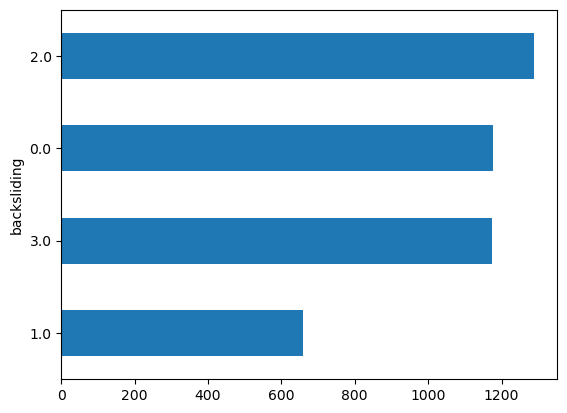

In [6]:
# Count the different classes to check how balanced they are
value_counts_dimension1 = df_labelled['backsliding'].value_counts()
value_counts_dimension1.sort_values().plot(kind="barh")

In [7]:
FRACTION_OF_DS_TO_USE = 1
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
NO_LABELS = len(labels)
MAX_LOSS = 0.05

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [8]:
# Use part of the dataset
new_df = df_labelled.sample(frac=FRACTION_OF_DS_TO_USE, random_state=200)
# Display a sample of the dataset
new_df.sample(10)[['sentence', 'label_vector']]

,sentence,label_vector
455388,it is important that this reform safeguard jud...,"[1, 0, 0, 0]"
457703,reforms of the justice system have been adopte...,"[0, 0, 0, 1]"
456586,prosecutors are nominated by the minister of j...,"[0, 0, 0, 1]"
13292,"""Homophobic rhetoric by government figures, in...","[0, 0, 1, 0]"
354,"""German police recorded 632 politically motiva...","[1, 0, 0, 0]"
63428,"""Jovanovski had played the role of an informal...","[1, 0, 0, 0]"
456725,"directorate-general for communication (2020), ...","[1, 0, 0, 0]"
669,"""Though parties are legally required to achiev...","[0, 0, 1, 0]"
1235,"""In recent years, multiple public figures—incl...","[0, 0, 1, 0]"
456042,members of the house of representatives maarte...,"[1, 0, 0, 0]"


In [9]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.sentence
        self.targets = self.data.label_vector
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [10]:
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (4304, 14)
TRAIN Dataset: (3443, 14)
TEST Dataset: (861, 14)


In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [12]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class ROBERTAClass(torch.nn.Module):
    def __init__(self):
        super(ROBERTAClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, NO_LABELS)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = ROBERTAClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROBERTAClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [13]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [14]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [15]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        if loss.item() < MAX_LOSS:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [16]:
# Train
for epoch in range(EPOCHS):
    loss = train(epoch)
    print(f'Epoch {epoch} done')
    if loss.item() < MAX_LOSS:
        print(f'Loss minimized to below {MAX_LOSS}')
        break

Epoch: 0, Loss:  0.7158207893371582
Epoch 0 done
Epoch: 1, Loss:  0.40101897716522217
Epoch 1 done
Epoch: 2, Loss:  0.504323422908783
Epoch 2 done
Loss minimized to below 0.05


In [17]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [18]:
# Validation
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
# Check https://stephenallwright.com/micro-vs-macro-f1-score/

Accuracy Score = 0.686411149825784
F1 Score (Micro) = 0.7080597014925373
F1 Score (Macro) = 0.6979792585025344


In [19]:
# Test our inputs
# Choose a sentence
#sample_row = new_df.sample()[['sentence', 'label_vector']]
sample_row = df_labelled.sample()[['sentence']]
sample_text = sample_row['sentence'].values[0]
print(sample_text)

"The 2018 electoral law permits the formation of alliances to contest elections, allowing parties that would not meet the threshold alone to secure seats through an alliance.


In [20]:
def get_dimension_from_prediction(v, l=labels):    
    index = v.index(max(v))    
    return l[index]
    
# Encode the sentence
encoding = tokenizer.encode_plus(
  sample_text.lower(),
  add_special_tokens=True,
  max_length=MAX_LEN,
  padding='max_length',
  truncation=True,
  return_token_type_ids=True,
  return_tensors='pt'
)

input_ids = encoding["input_ids"]
mask = encoding["attention_mask"]
token_type_ids = encoding["token_type_ids"]
input_ids = input_ids.to(device, dtype=torch.long)
mask = mask.to(device, dtype=torch.long)
token_type_ids = token_type_ids.to(device, dtype=torch.long)

# Inference
output = torch.sigmoid(model(input_ids, mask, token_type_ids))
predictions = output[0].tolist()
for label, prediction in zip(labels, predictions):
    print(f"{label}: {prediction}")

0.0: 0.015086310915648937
1.0: 0.7442055940628052
2.0: 0.032417844980955124
3.0: 0.3585065007209778


In [21]:
result_dim = get_dimension_from_prediction(predictions)
print(f'Statement "{sample_text}" was classified as: {result_dim}.')

Statement ""The 2018 electoral law permits the formation of alliances to contest elections, allowing parties that would not meet the threshold alone to secure seats through an alliance." was classified as: 1.0.


In [22]:
# Save model
torch.save(model, 'ROBERTA_sentiment_classifier_democracy.pth')
#torch.save(model.state_dict(), 'ROBERTA_classifier_democracy_state_dict.pth')